# Multimodal model
## Fine-tuning GIT (GenerativeImage2Text) model for image captioning

In [1]:
# Standard library imports
from textwrap import wrap
import warnings

# Third-party imports
from accelerate.test_utils.testing import get_backend
import matplotlib.pyplot as plt
import numpy as np

# Hugging Face imports
from datasets import load_dataset
from datasets.dataset_dict import DatasetDict
from evaluate import load
from huggingface_hub import login
from transformers.models.auto.modeling_auto import AutoModelForCausalLM
from transformers.models.auto.processing_auto import AutoProcessor
from transformers.trainer import Trainer
from transformers.training_args import TrainingArguments
from transformers.models.auto.modeling_auto import AutoModelForImageTextToText

# Configure environment
warnings.filterwarnings("ignore")
login()

# Load Dataset

## Name: `pokemon-blip-captions`

- 833 captioned images of pokemons

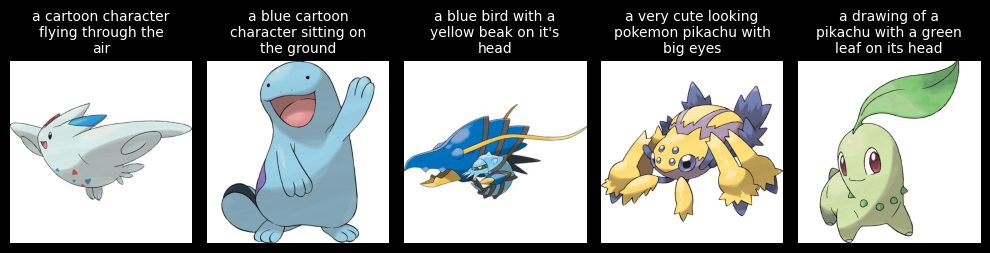

In [2]:
dataset: DatasetDict = load_dataset("reach-vb/pokemon-blip-captions")  # type: ignore
dataset = dataset["train"].train_test_split(test_size=0.05)
train_dataset = dataset["train"]
test_dataset = dataset["test"]

def display_images_with_captions(image_list, caption_list):
    num_images = len(image_list)
    plt.figure(figsize=(2 * num_images, 3))
    
    for index in range(num_images):
        plt.subplot(1, num_images, index + 1)
        wrapped_caption = "\n".join(wrap(caption_list[index], width=20))
        plt.imshow(image_list[index])
        plt.title(wrapped_caption, fontsize=10)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

num_samples = 5
images_to_show = [np.array(train_dataset[i]["image"]) for i in range(num_samples)]
captions_to_show = [train_dataset[i]["text"] for i in range(num_samples)]

display_images_with_captions(images_to_show, captions_to_show)

In [3]:
test_images_for_future_inference = [test_dataset["image"][i].copy() for i in range(3)]
test_captions_for_future_inference = [test_dataset["text"][i] for i in range(3)]

# Preprocess data

In [ ]:
checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


train_dataset.set_transform(transforms)
test_dataset.set_transform(transforms)

# Load model checkpoint & Set up training

In [5]:
model = AutoModelForCausalLM.from_pretrained(checkpoint)

model_name = checkpoint.split("/")[1]
training_args = TrainingArguments(
    output_dir=f"{model_name}-pokemon",
    learning_rate=5e-5,
    num_train_epochs=10,
    fp16=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=1000,
    logging_steps=100,
    remove_unused_columns=False,
    push_to_hub=True,
    label_names=["labels"],
    load_best_model_at_end=True,
)

# Train & Push to HF

In [6]:
wer = load("wer")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# trainer.train()  # training took 35 min
# trainer.push_to_hub()

# Training logs:

| Step | Training Loss | Validation Loss | Wer Score  |
|------|---------------|-----------------|------------|
| 200  | 0.109600      | 0.045895        | 5.217722   |
| 400  | 0.025500      | 0.041870        | 3.106329   |

# Load trained model from HF

In [7]:
# processor = AutoProcessor.from_pretrained("NikolaySkripko/git-base-pokemon")
model = AutoModelForImageTextToText.from_pretrained("NikolaySkripko/git-base-pokemon")

# Inference example

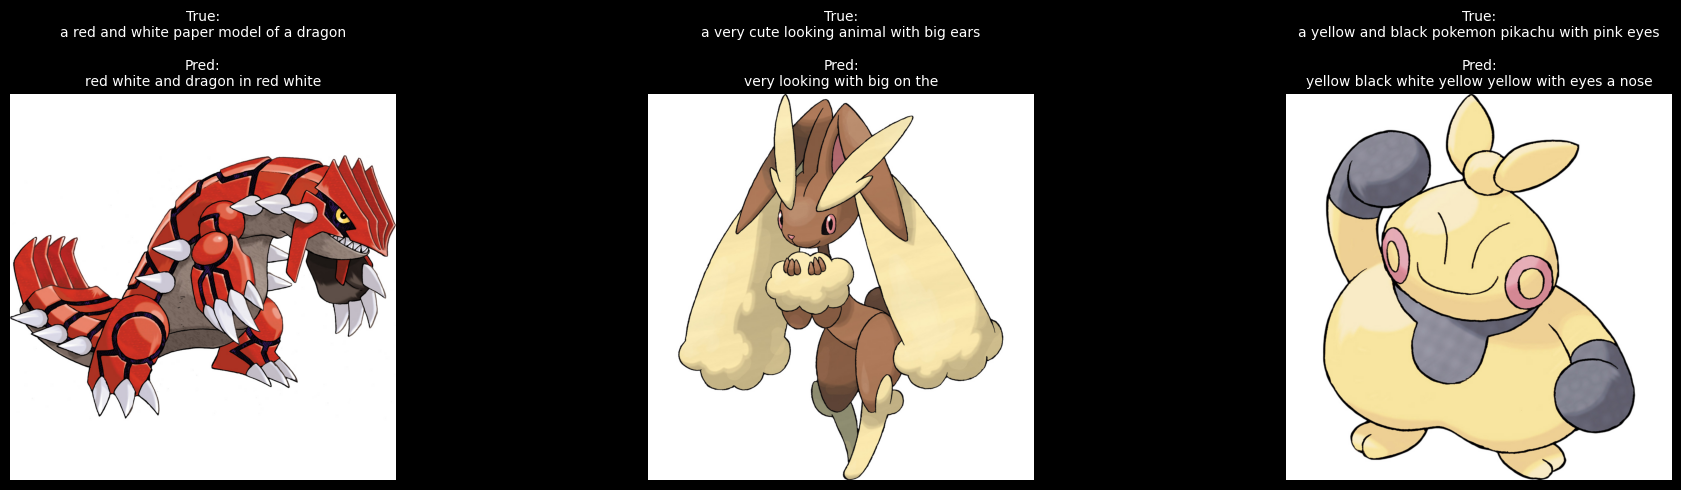

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, (test_image, test_caption) in enumerate(zip(test_images_for_future_inference, test_captions_for_future_inference)):
    if i >= 3:
        break

    device, _, _ = get_backend()
    inputs = processor(images=test_image, return_tensors="pt").to(device)
    model.to(device)
    pixel_values = inputs.pixel_values
    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Plotting
    ax = axes[i]
    ax.imshow(test_image)
    ax.axis('off')
    ax.set_title(f"True:\n{test_caption}\n\nPred:\n{generated_caption}", fontsize=10)

plt.tight_layout()
plt.show()

# Выводы

- Обучение стабильное, но 35 минут очень мало
- Модель выучила паттерны в описании покемонов: упоминания цветов, слов по типу `cartoon` или `drawing`
- Captioning вышли грамматически несвязными, но отражающими основные детали (`big`, `black`, `with eyes` etc)  

